# Implementing Soft-Actor-Critic V2  (no Value network)
(https://arxiv.org/abs/1812.05905)
### References: 
OpenAI Gym <br/>
https://github.com/ajaysub110/sac-pytorch

In [41]:
import simulation
import sys
import random
import pandas as pd
import importlib
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import torch.distributions as tdist
import torch.optim as opt
from collections import deque

In [76]:
TAU = 0.005
EPSILON = 1e-6
H_DIM = 32
LR = 3e-4
REPLAY_MEMORY_SIZE = 50000
ALPHA = 0.2
GAMMA = 0.99 # 0.98
ENTROPY_TUNING = True # True
MIN_LOG = -20
MAX_LOG = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [77]:
#HElper
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        torch.nn.init.constant_(m.bias, 0)
def copy_params(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

def soft_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - TAU) + param.data * TAU)

In [78]:
class ReplayMemory:
    def __init__(self,size):
        self.size = size
        self.memory = deque([],maxlen=size)

    def push(self, x):
        self.memory.append(x)
    
    def sample(self, batch_size):
        if(batch_size <= self.get_len()):
            batch = random.sample(self.memory,batch_size)
            state, action, reward, next_state, done = map(np.stack, zip(*batch))
            return state, action, reward, next_state, done
        return None, None, None, None, None

    def get_len(self):
        return len(self.memory)

In [79]:
class Space():
    def __init__(self, low, high, length, dtype):
        self.shape = (length)
        self.dtype = np.dtype(dtype)
        self.low_bound = low
        self.high_bound = high
        self.low = np.ones(length)*low
        self.high = np.ones(length)*high

class ActionSpace(Space):
    def __init__(self, low = 0, high = 10, length=24, dtype= np.float32):
        super().__init__(low, high, length, dtype)
    
    def sample(self):
        return np.random.uniform(self.low_bound,self.high_bound,self.shape)

class StateSpace(Space):
    def __init__(self, low = 0, high = 100, length=24, dtype= np.float32):
        super().__init__(low, high, length, dtype)

class NormalizedActions(ActionSpace):
    def __init__(self):
        self.action_space = ActionSpace()
        self.state_space = StateSpace()
        
    def _action(self, action):
        """
        Input: Action- a np_array of length= self.length (self refers to NormalizedActions)
        Returns: "normalized action"
        """
        low  = self.low
        high = self.high
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.low
        high = self.high
        action_prime = []
        for x in np.nditer(action):
            x_prime = 2*(x-low) / (high-low) - 1
            action_prime.append(x_prime)
        action_prime = np.array(action_prime)
        action_prime = np.clip(action_prime, low, high)
        
        return action_prime
    
    def step(self, office, price, controllers_points):
        end = False
        energy_dict = {}
        rewards_dict = {}
        # DO per person reward!!
        # Add per person to parameter ^^^^
        # Add i to the state 
        # or add map i: kwh_i, or reference yesterday player energy
        count = 0
        energy = None
        for player_name in office.players_dict:
            if(count < 100000000):
                player = office.players_dict.get(player_name)
                player_energy = player.linear_response(controllers_points)
                energy = player_energy
                last_player_energy = player_energy
                energy_dict[player_name] = player_energy

                player_min_demand = player.get_min_demand()
                player_max_demand = player.get_max_demand()
                player_reward = simulation.Reward(player_energy, price[0:24], player_min_demand, player_max_demand)
                player_ideal_demands = player_reward.ideal_use_calculation()
                last_player_ideal = player_ideal_demands
                reward = player_reward.scaled_cost_distance_neg(player_ideal_demands)
                rewards_dict[player_name] = reward
                count += 1
        
        total_reward = sum(rewards_dict.values())
        office._timestep = office._timestep + office._time_interval
        
        if office._timestep>office._end_timestamp:
            office._timestep = office._start_timestamp

        #Traininng on one day!
        diff = (office.get_timestep()-office._start_timestamp)
        next_price = price #office.price_signal(diff.days + 1)
        next_state = next_price #np.concatenate([next_price, energy])
        return next_state, total_reward, end

In [80]:
class QNetwork(nn.Module):
    def __init__(self,s_dim,a_dim,h_dim):
        super(QNetwork,self).__init__()

        self.linear1 = nn.Linear(s_dim+a_dim,h_dim)
        self.linear2 = nn.Linear(h_dim,h_dim)
        self.linear3 = nn.Linear(h_dim,1)

        self.apply(init_weights)

    def forward(self,s,a):
        x = torch.cat((s,a),dim=1)
        x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        #x = self.linear3(x)

        return x
        
class PolicyNetwork(nn.Module):
    def __init__(self,s_dim,a_dim,h_dim,action_space):
        super(PolicyNetwork,self).__init__()

        self.linear1 = nn.Linear(s_dim,h_dim)
        self.linear2 = nn.Linear(h_dim,h_dim)

        self.linear3a = nn.Linear(h_dim,a_dim)
        self.linear3b = nn.Linear(h_dim,a_dim)

        # Apply weight initialisation to all linear layers
        self.apply(init_weights)    

        # rescale actions
        if action_space is None:
            self.action_scale = torch.tensor(1.)
            self.action_bias = torch.tensor(0.)
        else:
            self.action_scale = torch.FloatTensor(
                (action_space.high - action_space.low) / 2.)
            self.action_bias = torch.FloatTensor(
                (action_space.high + action_space.low) / 2.)

    def forward(self,s):
        x = F.relu(self.linear1(s))
        #x = F.relu(self.linear2(x))
        mean = self.linear3a(x)
        log_std = self.linear3b(x)

        # constrain log value in finite range to avoid NaN loss values
        log_std = torch.clamp(log_std, min=MIN_LOG, max=MAX_LOG)
        
        return mean, log_std

    def sample_action(self,s):
        mean, log_std = self.forward(s)
        std = log_std.exp()

        # calculate action using reparameterization trick and action scaling
        normal = Normal(mean, std)
        xi = normal.rsample()
        yi = torch.tanh(xi)
        a = yi * self.action_scale + self.action_bias
        log_pi = normal.log_prob(xi)

        # enforcing action bound (appendix of paper)
        log_pi -= torch.log(self.action_scale * (1 - yi.pow(2)) + EPSILON)
        log_pi = log_pi.sum(1,keepdim=True)
        mean = torch.tanh(mean)*self.action_scale + self.action_bias

        return a, log_pi, mean

In [81]:
class SoftActorCritic(object):
    def __init__(self,observation_space,action_space):
        self.s_dim = observation_space.shape
        self.a_dim = action_space.shape
        self.alpha = ALPHA

        # create component networks
        self.q_network_1 = QNetwork(self.s_dim,self.a_dim,H_DIM).to(device)
        self.q_network_2 = QNetwork(self.s_dim,self.a_dim,H_DIM).to(device)
        self.target_q_network_1 = QNetwork(self.s_dim,self.a_dim,H_DIM).to(device)
        self.target_q_network_2 = QNetwork(self.s_dim,self.a_dim,H_DIM).to(device)
        self.policy_network = PolicyNetwork(self.s_dim, self.a_dim, H_DIM, action_space).to(device)

        # copy weights from q networks to target networks
        copy_params(self.target_q_network_1, self.q_network_1)
        copy_params(self.target_q_network_2, self.q_network_2)
        
        # optimizers
        self.q_network_1_opt = opt.Adam(self.q_network_1.parameters(),LR)
        self.q_network_2_opt = opt.Adam(self.q_network_2.parameters(),LR)
        self.policy_network_opt = opt.Adam(self.policy_network.parameters(),LR)
        
        # automatic entropy tuning
        if ENTROPY_TUNING:
            self.target_entropy = -torch.prod(torch.Tensor(action_space.shape).to(device)).item()
            self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
            self.alpha_optim = opt.Adam([self.log_alpha], lr=LR)
                
        self.replay_memory = ReplayMemory(REPLAY_MEMORY_SIZE)

    def get_action(self, s):
        state = torch.FloatTensor(s).to(device).unsqueeze(0)
        action, _, _ = self.policy_network.sample_action(state)
        return action.detach().cpu().numpy()[0]

    def update_params(self, batch_size):
        states, actions, rewards, next_states, ndones = self.replay_memory.sample(batch_size)
        
        # make sure all are torch tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        ndones = torch.FloatTensor(np.float32(ndones)).unsqueeze(1).to(device)

        # compute targets
        with torch.no_grad():
            next_action, next_log_pi,_ = self.policy_network.sample_action(next_states)
            next_target_q1 = self.target_q_network_1(next_states,next_action)
            next_target_q2 = self.target_q_network_2(next_states,next_action)
            next_target_q = torch.min(next_target_q1,next_target_q2) - self.alpha*next_log_pi
            next_q = rewards + GAMMA*next_target_q

        # compute losses
        q1 = self.q_network_1(states,actions)
        q2 = self.q_network_2(states,actions)

        q1_loss = F.mse_loss(q1,next_q)
        q2_loss = F.mse_loss(q2,next_q)
        
        pi, log_pi,_ = self.policy_network.sample_action(states)
        q1_pi = self.q_network_1(states,pi)
        q2_pi = self.q_network_2(states,pi)
        min_q_pi = torch.min(q1_pi,q2_pi)

        policy_loss = ((self.alpha * log_pi) - min_q_pi).mean()

        # gradient descent
        self.q_network_1_opt.zero_grad()
        q1_loss.backward()
        self.q_network_1_opt.step()

        self.q_network_2_opt.zero_grad()
        q2_loss.backward()
        self.q_network_2_opt.step()

        self.policy_network_opt.zero_grad()
        policy_loss.backward()
        self.policy_network_opt.step()

        # alpha loss
        if ENTROPY_TUNING:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
            
            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()

            self.alpha = self.log_alpha.exp()
        else:
            alpha_loss = torch.tensor(0.).to(device)

        # update target network params
        soft_update(self.target_q_network_1,self.q_network_1)
        soft_update(self.target_q_network_2,self.q_network_2)

        return q1_loss.item(), q2_loss.item(), policy_loss.item(), alpha_loss.item()

In [83]:
env = NormalizedActions()
agent = SoftActorCritic(env.state_space, env.action_space)
replay_size = 100000
memory = ReplayMemory(replay_size)
agent.replay_memory = memory
total_numsteps = 1000
start_steps = 110
batch_size = 25
action_star = None
rewards = []
office = simulation.Office()
diff = (office.get_timestep()-office._start_timestamp)
state = office.price_signal(diff.days + 50) #np.concatenate([office.price_signal(diff.days + 50), np.zeros(24)])
full_rewards = []
alphas = [0.1111] #np.linspace(0,1,10)
for alpha in alphas:
    print("--------------------------")
    print("Alpha = " + str(alpha))
    print("--------------------------")
    ALPHA = alpha
    for step in range(total_numsteps):
        print(str(step) + " / " + str(total_numsteps))
        if start_steps > step:
            action = env.action_space.sample()  # Sample random action
        else:
            action = agent.get_action(state)  # Sample action from policy

        next_state, reward, done = env.step(office, state, action)
        memory.push((state, action, reward, next_state, done))
        state = next_state
        action_star = action

        if(memory.get_len() > batch_size):
            critic_1_loss, critic_2_loss, policy_loss, alpha = agent.update_params(batch_size)

        rewards.append(reward)

    rewards = [r[0] if r is np.ndarray else r for r in rewards]
    full_rewards.append(rewards)
    rewards = []

creating agents
creating controller
--------------------------
Alpha = 0.1111
--------------------------
0 / 1000
1 / 1000
2 / 1000
3 / 1000
4 / 1000
5 / 1000
6 / 1000
7 / 1000
8 / 1000
9 / 1000
10 / 1000
11 / 1000
12 / 1000
13 / 1000
14 / 1000
15 / 1000
16 / 1000
17 / 1000
18 / 1000
19 / 1000
20 / 1000
21 / 1000
22 / 1000
23 / 1000
24 / 1000
25 / 1000
26 / 1000
27 / 1000
28 / 1000
29 / 1000
30 / 1000
31 / 1000
32 / 1000
33 / 1000
34 / 1000
35 / 1000
36 / 1000
37 / 1000
38 / 1000
39 / 1000
40 / 1000
41 / 1000
42 / 1000
43 / 1000
44 / 1000
45 / 1000
46 / 1000
47 / 1000
48 / 1000
49 / 1000
50 / 1000
51 / 1000
52 / 1000
53 / 1000
54 / 1000
55 / 1000
56 / 1000
57 / 1000
58 / 1000
59 / 1000
60 / 1000
61 / 1000
62 / 1000
63 / 1000
64 / 1000
65 / 1000
66 / 1000
67 / 1000
68 / 1000
69 / 1000
70 / 1000
71 / 1000
72 / 1000
73 / 1000
74 / 1000
75 / 1000
76 / 1000
77 / 1000
78 / 1000
79 / 1000
80 / 1000
81 / 1000
82 / 1000
83 / 1000
84 / 1000
85 / 1000
86 / 1000
87 / 1000
88 / 1000
89 / 1000
90 / 

746 / 1000
747 / 1000
748 / 1000
749 / 1000
750 / 1000
751 / 1000
752 / 1000
753 / 1000
754 / 1000
755 / 1000
756 / 1000
757 / 1000
758 / 1000
759 / 1000
760 / 1000
761 / 1000
762 / 1000
763 / 1000
764 / 1000
765 / 1000
766 / 1000
767 / 1000
768 / 1000
769 / 1000
770 / 1000
771 / 1000
772 / 1000
773 / 1000
774 / 1000
775 / 1000
776 / 1000
777 / 1000
778 / 1000
779 / 1000
780 / 1000
781 / 1000
782 / 1000
783 / 1000
784 / 1000
785 / 1000
786 / 1000
787 / 1000
788 / 1000
789 / 1000
790 / 1000
791 / 1000
792 / 1000
793 / 1000
794 / 1000
795 / 1000
796 / 1000
797 / 1000
798 / 1000
799 / 1000
800 / 1000
801 / 1000
802 / 1000
803 / 1000
804 / 1000
805 / 1000
806 / 1000
807 / 1000
808 / 1000
809 / 1000
810 / 1000
811 / 1000
812 / 1000
813 / 1000
814 / 1000
815 / 1000
816 / 1000
817 / 1000
818 / 1000
819 / 1000
820 / 1000
821 / 1000
822 / 1000
823 / 1000
824 / 1000
825 / 1000
826 / 1000
827 / 1000
828 / 1000
829 / 1000
830 / 1000
831 / 1000
832 / 1000
833 / 1000
834 / 1000
835 / 1000
836 / 1000

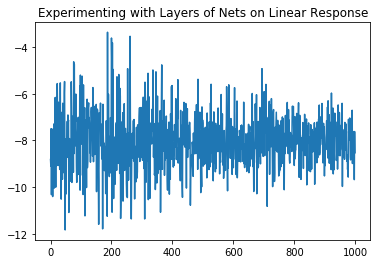

In [84]:
#print(full_rewards)
i = 0
for reward in full_rewards:
    plt.figure()
    plt.title("Experimenting with Layers of Nets on Linear Response")
    plt.plot(np.array(reward))
    #plt.legend(loc='best')
    i+=1
    

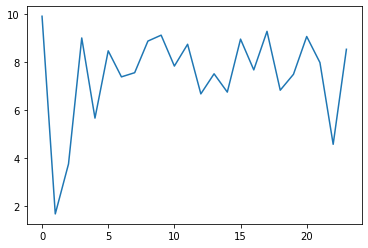

In [85]:
plt.plot(np.array(range(24)),action_star)

[9.919153  1.6676643 3.7529464 9.0121975 5.667174  8.475151  7.3884583
 7.5630083 8.882667  9.129163  7.839615  8.749296  6.6780834 7.5162086
 6.7526755 8.963812  7.679785  9.288906  6.832193  7.4962053 9.073364
 7.9856143 4.5735874 8.539839 ]
----
[8.882667  9.129163  7.839615  8.749296  6.6780834 7.5162086 6.7526755
 8.963812  7.679785 ]


Text(0.5, 1.0, 'Price of Energy Today (SAC V3)')

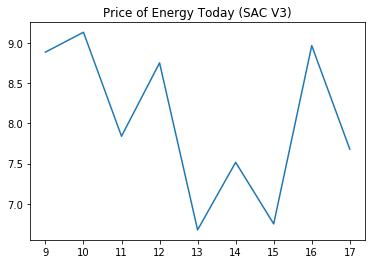

In [86]:
action_prime = action_star[8:17]
print(action_star)
print("----")
print(action_prime)
plt.plot(np.array([i for i in range(9,18)]),np.array(action_prime))
plt.title("Price of Energy Today (SAC V3)")